The goal of this project is to experiment with and combine different models to solve a task. I decided that I would combine an Autoencoder for dimensionality reduction and then use the encoded features in an ANN for the purposes of classification.

AutoEncoders are a type of neural network which are trained to learn to copy the input to the output. It consists of an encoder which encodes or breaks down the input into lower dimension representation, and then has an encoder which decodes the lower dimension representation back to its input. From being used for dimensionality reduction and recommendation systems to denoising images and image colorization, Autoencoders have many interesting applications.

<br>

**Why combine an Autoencoder for dimensionality reduction with an ANN?**

Dimensionality reduction is important as not only does it reduce computational requirements, but it also can help prevent overfitting and ultimately result in a better performance, as dimensionality reduction aims to extract only the meaningful features from the data.

## Library Imports

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from ucimlrepo import fetch_ucirepo

## Loading the Dataset

The dataset was obtained from the UCI Machine Learning Repository and contains information about a set of molecules. This dataset allows for a binary classification task, with the goal of predicting whether a molecule is a musk or not.

Here is some information from the UCI Machine Learning Repository about our variables:

- f1 through f162 are distance features (in hundredths of Angstroms) which can be positive or negative
- f163 is the distance of oxygen atom to a designated point in 3-space (OXY-DIS)
- f164 is the X displacement from the mentioned designated point (OXY-X)
- f165 is the Y displacement from the mentioned designated point (OXY-Y)
- f166 is the Z displacement from the mentioned designated point (OXY-Z)

In [ ]:
# UCI Machine Learning Repository developed a library to easily import datasets in Python
# This code to load the data comes from their website at https://archive.ics.uci.edu/dataset/75/musk+version+2

# fetch dataset
musk_version_2 = fetch_ucirepo(id=75)

# data (as pandas dataframes)
X = musk_version_2.data.features
y = musk_version_2.data.targets

# # metadata
# print(musk_version_2.metadata)

# # variable information
# print(musk_version_2.variables)

{'uci_id': 75, 'name': 'Musk (Version 2)', 'repository_url': 'https://archive.ics.uci.edu/dataset/75/musk+version+2', 'data_url': 'https://archive.ics.uci.edu/static/public/75/data.csv', 'abstract': 'The goal is to learn to predict whether new molecules will be musks or non-musks', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6598, 'num_features': 166, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': ['molecule_name', 'conformation_name'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C51608', 'creators': ['David Chapman', 'Ajay Jain'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks.  The goal is to learn to predi

In [ ]:
X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,46,-108,-60,-69,-117,49,38,-161,-8,5,...,-244,-308,52,-7,39,126,156,-50,-112,96
1,41,-188,-145,22,-117,-6,57,-171,-39,-100,...,-235,-59,-2,52,103,136,169,-61,-136,79
2,46,-194,-145,28,-117,73,57,-168,-39,-22,...,-238,-134,-154,57,143,142,165,-67,-145,39
3,41,-188,-145,22,-117,-7,57,-170,-39,-99,...,-236,-60,-4,52,104,136,168,-60,-135,80
4,41,-188,-145,22,-117,-7,57,-170,-39,-99,...,-236,-60,-4,52,104,137,168,-60,-135,80


In [ ]:
X.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       ...
       'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165',
       'f166'],
      dtype='object', length=166)

## Data Preprocessing

In [ ]:
X.shape

(6598, 166)

As we can see, there are many features, which is ideal for our dimensionality reduction task, and is one of the reasons I chose this dataset.

In [ ]:
X.dtypes.unique()

array([dtype('int64')], dtype=object)

In [ ]:
y['class'].unique()

array([1., 0.])

In addition, we can see that our target variables are binary.

First, let's check for missing values.

In [ ]:
X.isnull().sum().sum()

0

We should now split and scale our data befored training our models, as scaling the data is essential when working with deep learning models.

In [ ]:
scaler = StandardScaler()

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=3)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Dimensionality Reduction - Autoencoder

As previously mentioned, I will use an Autoencoder to reduce the number of features upon which the ANN will be trained. In order to do so, the Autoencoder must be trained, and then we will pass our data through the encoder portion of the Autoencoder only, so that our data is compressed into a smaller subspace. First, let's define the autoencoder class:

In [ ]:
class Autoencoder(models.Model):
  def __init__(self, dims):
    super(Autoencoder, self).__init__()
    self.encoder = models.Sequential([
        layers.Input(shape=(dims,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu')
    ])

    self.decoder = models.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(dims, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Now, we can train the autoencoder.

In [ ]:
dims = x_train.shape[1]
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

autoencoder = Autoencoder(dims)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

autoencoder_history = autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                batch_size=32,
                validation_data=(x_test, x_test),
                callbacks=es)

Epoch 1/50
145/145 [==============================] - 3s 5ms/step - loss: 0.9133 - val_loss: 0.8173
Epoch 2/50
145/145 [==============================] - 1s 5ms/step - loss: 0.8075 - val_loss: 0.7930
Epoch 3/50
145/145 [==============================] - 1s 5ms/step - loss: 0.7841 - val_loss: 0.7687
Epoch 4/50
145/145 [==============================] - 1s 5ms/step - loss: 0.7592 - val_loss: 0.7456
Epoch 5/50
145/145 [==============================] - 1s 4ms/step - loss: 0.7371 - val_loss: 0.7278
Epoch 6/50
145/145 [==============================] - 1s 5ms/step - loss: 0.7246 - val_loss: 0.7206
Epoch 7/50
145/145 [==============================] - 1s 4ms/step - loss: 0.7188 - val_loss: 0.7161
Epoch 8/50
145/145 [==============================] - 1s 5ms/step - loss: 0.7137 - val_loss: 0.7129
Epoch 9/50
145/145 [==============================] - 1s 6ms/step - loss: 0.7101 - val_loss: 0.7075
Epoch 10/50
145/145 [==============================] - 1s 5ms/step - loss: 0.7058 - val_loss: 0.7038

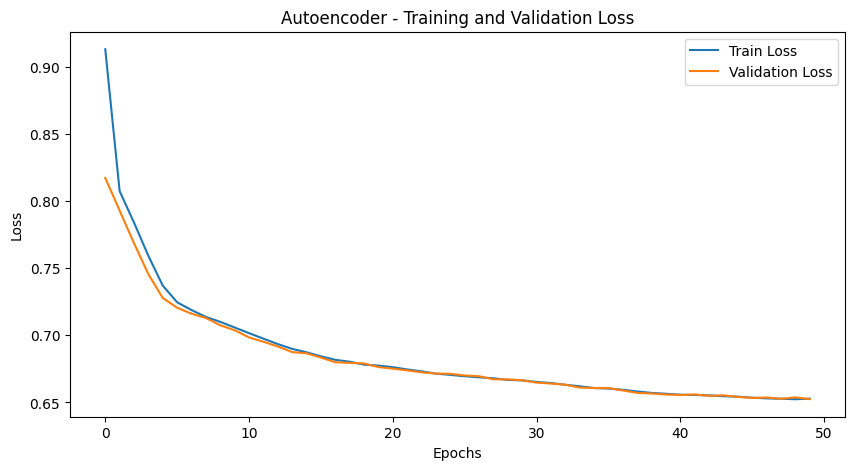

In [ ]:
def plot_AE_results(history):
  # Plot training history
  fig, ax = plt.subplots(1, 1, figsize=(10,5))

  ax.plot(history.history['loss'], label='Train Loss')
  ax.plot(history.history['val_loss'], label='Validation Loss')
  ax.set_title("Autoencoder - Training and Validation Loss")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")

  plt.legend()
  plt.show()

plot_AE_results(autoencoder_history)

Now that we have finished training the Autoencoder, I will pass the x_train and x_test arrays through the encoder portion of the model, thereby reducing the feature space:

In [ ]:
# apply our encoder to reduce the number of features

x_train_encoded = autoencoder.encoder(x_train).numpy()
x_test_encoded = autoencoder.encoder(x_test).numpy()

reduced_feats = x_train_encoded.shape[1]

print(f"We have now reduced the features from {dims} to {reduced_feats}")

We have now reduced the features from 166 to 16


## Classification - ANN

We can now build the ANN model for the binary classification task - musk or not musk.

I will first define a function to plot the loss and accuracy metrics of our ANN:

In [ ]:
def plot_ANN_results(history):
  # Plot training history
  fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15,5))

  ax1.plot(history.history['loss'], label='Train Loss')
  ax1.plot(history.history['val_loss'], label='Validation Loss')
  ax1.set_title("Loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")

  ax2.plot(history.history['accuracy'], label='Train Accuracy')
  ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax2.set_title("Accuracy")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")

  plt.show()

Now, I will define the neural network and train it:

In [ ]:
nn = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(reduced_feats,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') # sigmoid as it is binary classification
])

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)


nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')

classification_history = nn.fit(x_train_encoded, y_train, epochs=15, shuffle=True, batch_size=32,validation_data=(x_test_encoded, y_test), callbacks=es)

Epoch 1/15
145/145 [==============================] - 2s 6ms/step - loss: 1.1199 - accuracy: 0.7588 - val_loss: 0.4042 - val_accuracy: 0.8273
Epoch 2/15
145/145 [==============================] - 1s 5ms/step - loss: 0.3644 - accuracy: 0.8432 - val_loss: 0.3337 - val_accuracy: 0.8551
Epoch 3/15
145/145 [==============================] - 1s 8ms/step - loss: 0.3205 - accuracy: 0.8623 - val_loss: 0.3071 - val_accuracy: 0.8672
Epoch 4/15
145/145 [==============================] - 1s 9ms/step - loss: 0.2907 - accuracy: 0.8729 - val_loss: 0.2902 - val_accuracy: 0.8955
Epoch 5/15
145/145 [==============================] - 1s 8ms/step - loss: 0.2714 - accuracy: 0.8902 - val_loss: 0.2650 - val_accuracy: 0.8828
Epoch 6/15
145/145 [==============================] - 1s 7ms/step - loss: 0.2524 - accuracy: 0.8965 - val_loss: 0.2567 - val_accuracy: 0.9040
Epoch 7/15
145/145 [==============================] - 1s 4ms/step - loss: 0.2445 - accuracy: 0.9034 - val_loss: 0.2624 - val_accuracy: 0.9005
Epoch 

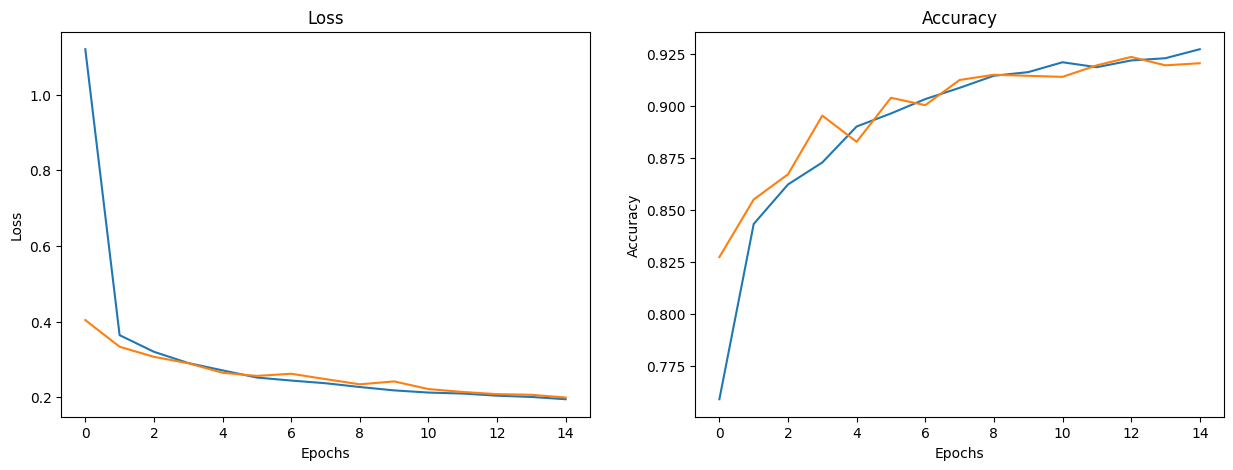

In [ ]:
plot_ANN_results(classification_history)

## Conclusion

Not only did this project serve as a way of experimenting with building neural networks using TensorFlow, as we can see from the plots above, we managed to reduce the number of features greatly (from 166 to 16) and still achieved a high accuracy (~92%) using the encoded data.